In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 로드

1. age : 나이
2. workclass : 직종
3. education_num : 교육 연수
4. marital_status : 결혼 상태
5. occupation : 직업
6. relationship : 관계
7. race : 인종
8. sex : 성별
9. capital_gain : 자본 이익
10. capital_loss : 자본 손실
11. hours_per_week : 주당 근로 시간
12. native_country : 출신 국가
13. target : 연 소득 5만달러 초과 여부(초과 1, 이하 0)

## 필요 라이브러리 및 데이터 로드

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler

X_train = pd.read_csv("/content/drive/Shareddrives/2022 KHU Summer Workshop/EDA & Machine Learning basic/Dataset/census_X_train.csv")
X_test = pd.read_csv("/content/drive/Shareddrives/2022 KHU Summer Workshop/EDA & Machine Learning basic/Dataset/census_X_test.csv")
y_train = pd.read_csv("//content/drive/Shareddrives/2022 KHU Summer Workshop/EDA & Machine Learning basic/Dataset/census_y_train.csv")

## 정보 확인

*   info method는 데이터프레임의 Dtype과 non null columns 등을 확인 할 수 있음
*   values_counts는 갯수를 세줌
*   central tendency를 summarize, NaN value 제외

In [ ]:
# 확인결과 결측치는 없음. target이 0,1이므로 분류모델이고, 갯수가 bias 되어 있음.
print(X_train.info())
print(y_train.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education_num   30162 non-null  int64 
 3   marital_status  30162 non-null  object
 4   occupation      30162 non-null  object
 5   relationship    30162 non-null  object
 6   race            30162 non-null  object
 7   sex             30162 non-null  object
 8   capital_gain    30162 non-null  int64 
 9   capital_loss    30162 non-null  int64 
 10  hours_per_week  30162 non-null  int64 
 11  native_country  30162 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.8+ MB
None
target
0         22654
1          7508
dtype: int64


In [ ]:
categoric_ = X_train.select_dtypes(include = ['object']).columns.tolist()
numeric_ = X_train.select_dtypes(exclude = ['object']).columns.tolist()

In [ ]:
# 수치형 변수 확인
print(X_train.describe())

                age  education_num  capital_gain  capital_loss  hours_per_week
count  30162.000000   30162.000000  30162.000000  30162.000000    30162.000000
mean      38.437902      10.121312   1092.007858     88.372489       40.931238
std       13.134665       2.549995   7406.346497    404.298370       11.979984
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000


# 데이터 전처리

## 결측치 및 이상치 확인

In [ ]:
# capital_gain, capital_loss 는 bias 되어있는것을 확인할 수 있음. 두 변수의 75 백분위수 ~ 100 백분위수 범위를 5 백분위수 단계로 쪼개서 살펴보기
# capital_gain은 전체 데이터에서 10%이내, capital_loss는 전체 데이터에서 5% 이내만 0보다 크다.
print(X_train['capital_gain'].quantile([q/20 for q in range(15, 21)])) # quantile(백분위수) -> 해당 데이터의 백분위수에 해당하는 데이터를 반환
print(X_train['capital_loss'].quantile([q/20 for q in range(15, 21)]))

0.75        0.0
0.80        0.0
0.85        0.0
0.90        0.0
0.95     5013.0
1.00    99999.0
Name: capital_gain, dtype: float64
0.75       0.0
0.80       0.0
0.85       0.0
0.90       0.0
0.95       0.0
1.00    4356.0
Name: capital_loss, dtype: float64


## 이상치 및 범주형 변수 변환

### 파생변수(Derived Variable)

In [ ]:
X_train['capital_gain'] = np.where(X_train['capital_gain'] > 0, 1, 0) # 0보다 gain이 크면 1, 아니면 0으로 바꿔준다.
X_train['capital_loss'] = np.where(X_train['capital_loss'] > 0, 1, 0)

X_test['capital_gain'] = np.where(X_test['capital_gain'] > 0, 1, 0)
X_test['capital_loss'] = np.where(X_test['capital_loss'] > 0, 1, 0)

categoric_ = X_train.select_dtypes(include = ['object']).columns.tolist()
numeric_ = X_train.select_dtypes(exclude = ['object']).columns.tolist()

In [ ]:
# 종속변수 값이 1일 때의 평균이 0일 때의 평균보다 더 크고, 차이가 있다. 수치형변수 모두 종속변수를 예측하는데 사용할 만 하다고 보인다.
train_df = pd.concat([X_train, y_train], axis=1)

for _col in numeric_:
  print('-'*80)
  print(_col)
  print(train_df.groupby(['target'])[_col].describe(), end='\n\n')

--------------------------------------------------------------------------------
age
          count      mean        std   min   25%   50%   75%   max
target                                                            
0       22654.0  36.60806  13.464631  17.0  26.0  34.0  45.0  90.0
1        7508.0  43.95911  10.269633  19.0  36.0  43.0  51.0  90.0

--------------------------------------------------------------------------------
education_num
          count       mean       std  min   25%   50%   75%   max
target                                                           
0       22654.0   9.629116  2.413596  1.0   9.0   9.0  10.0  16.0
1        7508.0  11.606420  2.368423  2.0  10.0  12.0  13.0  16.0

--------------------------------------------------------------------------------
capital_gain
          count      mean       std  min  25%  50%  75%  max
target                                                      
0       22654.0  0.041626  0.199738  0.0  0.0  0.0  0.0  1.0
1        

한 변수가 가질 수 있는 고유한 값의 개수를 카디널리티(cardinality)라고 하는데, 카디널리티가 높은 변수는 모델 성능에 악영향을 준다. 보통 100개 이상의 고유한 값을 가지면 카디널리티가 높다고 하는데, 이 경우 해당 변수를 제거하거나, 일부 범주를 합쳐 카디널리티를 낮출 수 있다. 우리는 학습 데이터의 양이 적지 않고, 변수 값들을 봤을 때 카디널리티에 의한 모델 성능 저하를 크게 우려하지 않아도 될 것으로 보인다.

In [ ]:
for _col in categoric_:
  print(train_df.groupby([_col], as_index=False)['target'].mean().sort_values(by='target', ascending=False), end='\n\n')

          workclass    target
3      Self-emp-inc  0.558659
0       Federal-gov  0.387063
1         Local-gov  0.294630
4  Self-emp-not-inc  0.285714
5         State-gov  0.268960
2           Private  0.218792
6       Without-pay  0.000000

          marital_status    target
1      Married-AF-spouse  0.476190
2     Married-civ-spouse  0.454959
0               Divorced  0.107262
6                Widowed  0.096735
3  Married-spouse-absent  0.083784
5              Separated  0.070288
4          Never-married  0.048324

           occupation    target
3     Exec-managerial  0.485220
9      Prof-specialty  0.448489
10    Protective-serv  0.326087
12       Tech-support  0.304825
11              Sales  0.270647
2        Craft-repair  0.225310
13   Transport-moving  0.202926
0        Adm-clerical  0.133835
6   Machine-op-inspct  0.124619
4     Farming-fishing  0.116279
1        Armed-Forces  0.111111
5   Handlers-cleaners  0.061481
7       Other-service  0.041096
8     Priv-house-serv  0.00699

### Label encoding

문자열 값을 내림차순 정렬 후 0부터 1씩 증가하는 값으로 변환

숫자의 차이가 모델에 영향을 주지 않는 트리 계열 모델(랜덤포레스트 등)에 적용한다.

숫자의 차이가 모델에 영향을 미치는 선형 계열 모델(로지스틱 회귀, SVM) 등에는 사용하면 안된다.

In [ ]:
from sklearn.preprocessing import LabelEncoder
# X = pd.concat([X_train, X_test])
for _col in categoric_:
  le = LabelEncoder()
  # le.fit(X_train[_col]) # train에 fit 하고 test는 transform
  X_train[_col] = le.fit_transform(X_train[_col])
  X_test[_col] = le.transform(X_test[_col])

### One Hot Encoding

In [ ]:
# One Hot Encoder
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

In [ ]:
X_train

,age,education_num,capital_gain,capital_loss,hours_per_week,capital_gain_yn,capital_loss_yn,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,13,2174,0,40,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,12,0,0,38,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
30158,40,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
30159,58,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
30160,22,9,0,0,20,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## 불균형 데이터 처리

### 과대표집(OverSampling)

RandomOverSampler
*   Sample 복원추출해서 비율을 맞춰줌.
*   Sampling_strategy = minority, not minority, not majority, all, auto … 등등으로 설정해줄 수 있음.
*   Default 값은 auto
*   똑같은 데이터가 증식되므로 오버피팅의 위험이 있음.

SMOTE(Synthetic Minority Over-sampling Technique)
*   낮은 비율로 존재하는 클래스의 데이터를 최근접 이웃[k-NN 알고리즘] 알고리즘을 활용하여 새롭게 생성하는 방법이다.
*   소수 클래스의 데이터 중 특정 벡터(샘플)와 가장 가까운 k개의 이웃 벡터를 선정
*   기준 벡터와 선정한 벡터 사이를 선분으로 이음
*   선분 위의 임의의 점이 새로운 벡터(혹은 이 중 임의의 하나)








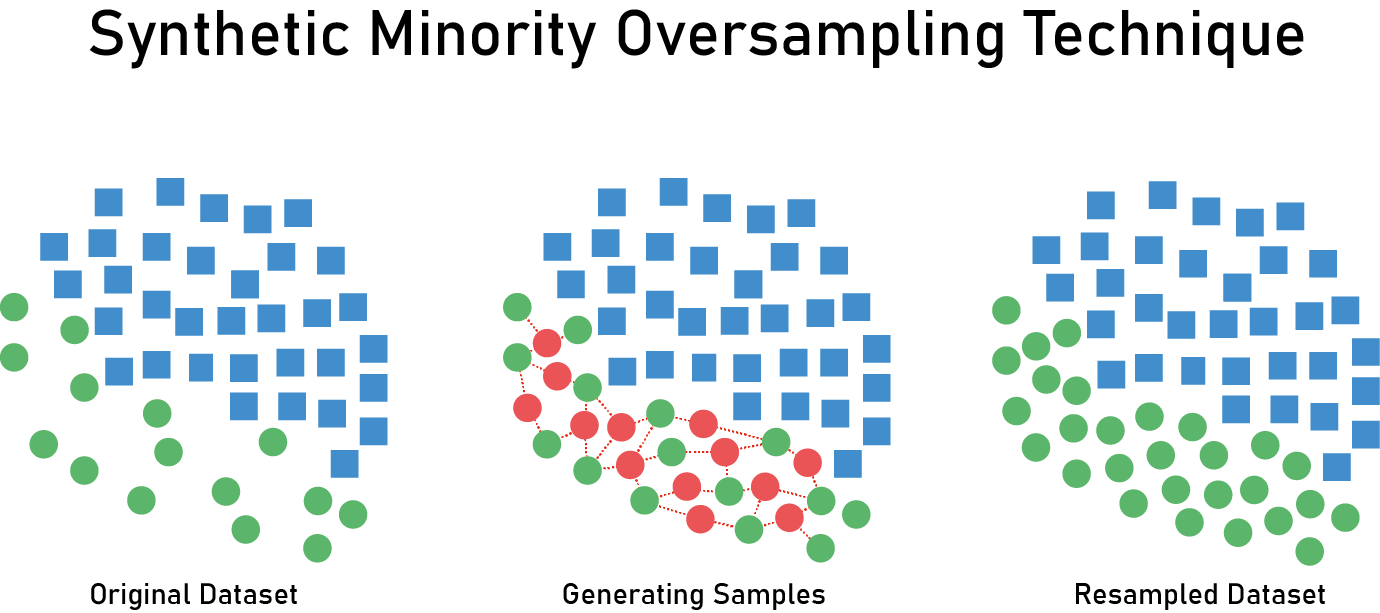

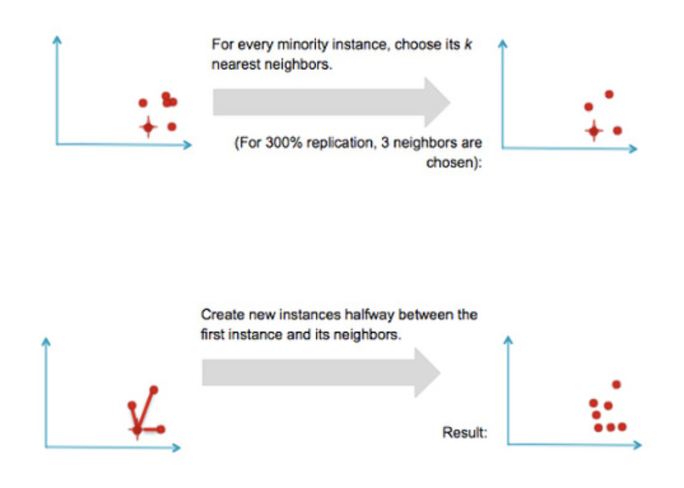

In [ ]:
# sampler = SMOTE(random_state=42)
sampler = RandomOverSampler(random_state=42)

X_train, y_train = sampler.fit_resample(X_train, y_train)
y_train.value_counts()

target
0         22654
1         22654
dtype: int64

# 학습 및 검증 데이터 분할, 스케일링

표준화(Standard Scaler)
*   피쳐의 값들이 평균이 0이고 표준편차가 1인 범위에 있도록 변환하다.
*   SVM 이나 선형회귀, 로지스틱회귀 등은 데이터셋이 표준정규분포를 따르 떄 성능이 좋은 모델이기 때문에 표준화를 하면 성능이 향상될 수 있다.

최대 최소 정규화(MinMaxScaler)
*   데이터셋의 모든 값은 0과 1 사이의 값으로 변환된다.
*   이상치의 영향을 크게 받는다.

MaxAbsScaler, RobustScaler 등등..
위의 경우가 아닐 때 어느게 좋을까? 써봐야안다.
써보고 성능 좋은거를 사용하자.

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) # stratify = target 으로 지정해주면 각각의 class의 비율을 train / validation에 유지해줍니다. 한쪽으로 쏠려서 분배되는 것을 방지합니다. # 아주 중요한 옵션

In [ ]:
y_tr.value_counts(), y_val.value_counts()

(target
 0         15858
 1         15857
 dtype: int64, target
 1         6797
 0         6796
 dtype: int64)

In [ ]:
len(X_tr), len(X_val)

(31715, 13593)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_tr[numeric_] = scaler.fit_transform(X_tr[numeric_])
X_val[numeric_] = scaler.transform(X_val[numeric_])
X_test[numeric_] = scaler.transform(X_test[numeric_])

In [ ]:
X_tr

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
4370,-0.822509,2,0.537525,4,12,1,4,0,-0.381802,-0.262673,-0.215139,38
21089,2.464611,2,-0.624469,2,11,0,4,1,-0.381802,3.807020,0.799440,38
14167,-0.742335,2,-0.624469,2,13,0,4,1,-0.381802,-0.262673,0.630343,38
11125,-0.020772,2,-0.624469,0,11,4,4,0,-0.381802,-0.262673,-1.060621,38
13826,-0.662161,2,0.924857,2,9,0,4,1,-0.381802,-0.262673,-0.215139,38
...,...,...,...,...,...,...,...,...,...,...,...,...
42191,1.101659,3,0.924857,2,3,0,4,1,-0.381802,-0.262673,-0.215139,38
38366,0.620617,2,0.924857,2,12,5,4,0,2.619155,-0.262673,-0.215139,38
9359,-0.261293,2,-0.624469,2,2,0,4,1,-0.381802,-0.262673,0.630343,38
22165,0.460270,2,-0.237137,2,0,5,4,0,-0.381802,-0.262673,-0.215139,38


# 학습 및 평가

## 모델 정의 및 훈련

Random Forest
* 배깅은 샘플을 여러번 뽑아 각각 모델을 학습시켜 결과물을 집계하는 방법(병렬학습)
* 의사결정 나무는 매우 훌륭한 모델이지만, 학습 데이터에 오버피팅 하는 경향이 있다. 가지치기(pruning) 같은 방법을 통해 그런 부작용을 최소하하는 전략이 있긴 하나 역시나 좀 부족하다.
* 랜덤 포레스트는 훈련을 통해 구성해놓은 다수의 나무들로부터 분류 결과를 취합해서 결론을 얻는, 배깅의의 대표적인 예시다.
* 물론 몇몇의 나무들이 오버피팅을 보일 순 있지만 다수의 나무를 기반으로 예측하기 때문에 그 영향력이 줄어들게 된어 좋은 일반화 성능을 보인다.

Xgboost
*   부스팅은 순차적으로 약한 학습자를 추가 결합하여 오차를 개선하여 하나의 강한 모델을 만드는 방법. 
*   배깅과 마찬가지로 복원 추출을 사용하는 데 샘플에 가중치를 부여함.
*   Tree 기반 알고리즘
*   새로운 약한 학습자를 훈련시킬 때 바로 전 약한 학습자의 학습 결과에서 잘못 예측된 샘플에 대한 가중치는 증가시키고 올바르게 예측된 샘플에 대한 가중치는 감소시켜서 사용
*   GBM 을 병렬학습이 지원되도록 구현한 라이브러리. 속도가 빠름
*   과적합 규제, Early Stopping 기능

LightGBM
*   Tree 기반 알고리즘
*   LIghtGBM은 Tree가 수직적(leaf wise)으로 확장되는 반면 다른 알고리즘은 수평적(level wise)으로 확장됨.
*   동일한 leaf를 확장할 때 leaf wise 알고리즘은 level wise 알고리즘보다 더 많은 loss 를 줄일 수 있음.
*   LightGBM은 큰 사이즈의 데이터를 다룰 수 있고, 실행시킬 때 적은 메모리를 차지함.
*   작은 데이터 세트에 사용하면 과적합 발생 위험.



















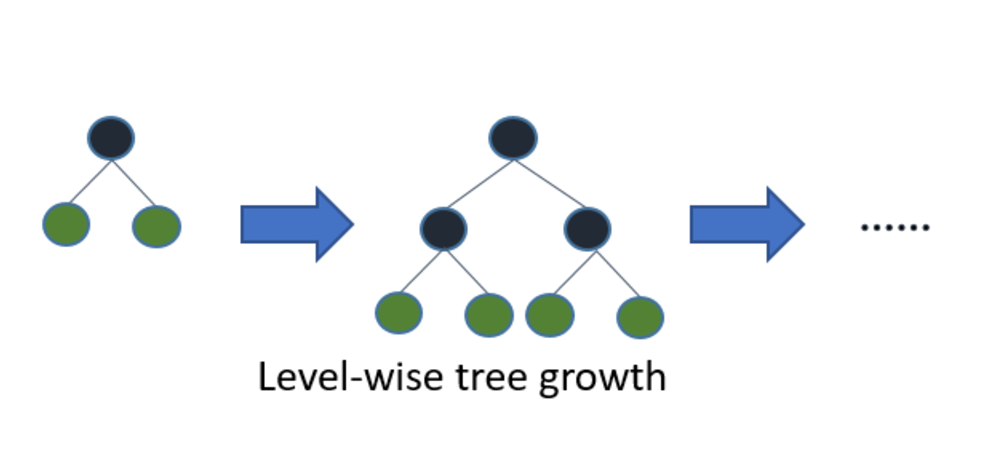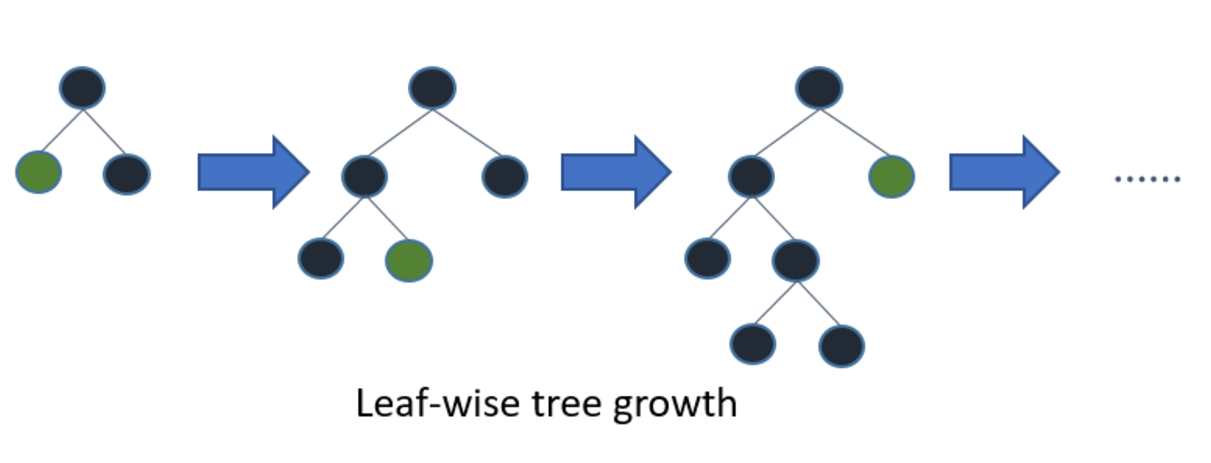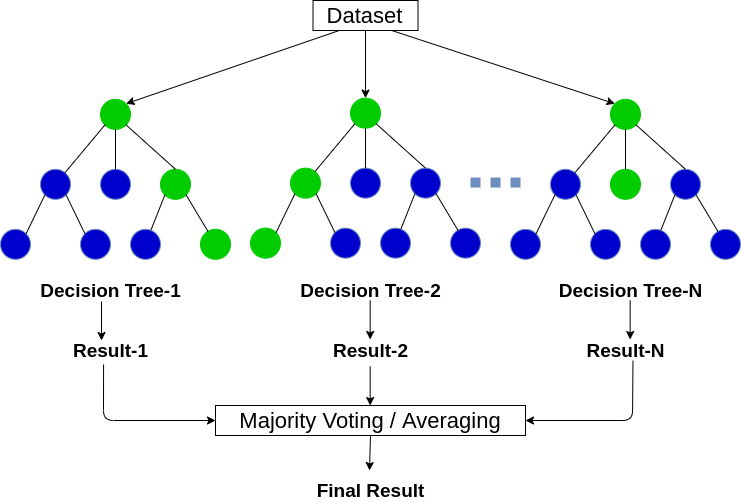

In [ ]:
y_tr.values.ravel()

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_tr, y_tr.values.ravel())

model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_tr, y_tr.values.ravel())

model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_tr, y_tr.values.ravel())

LGBMClassifier(random_state=42)

## 모델 검증

AUC.svg

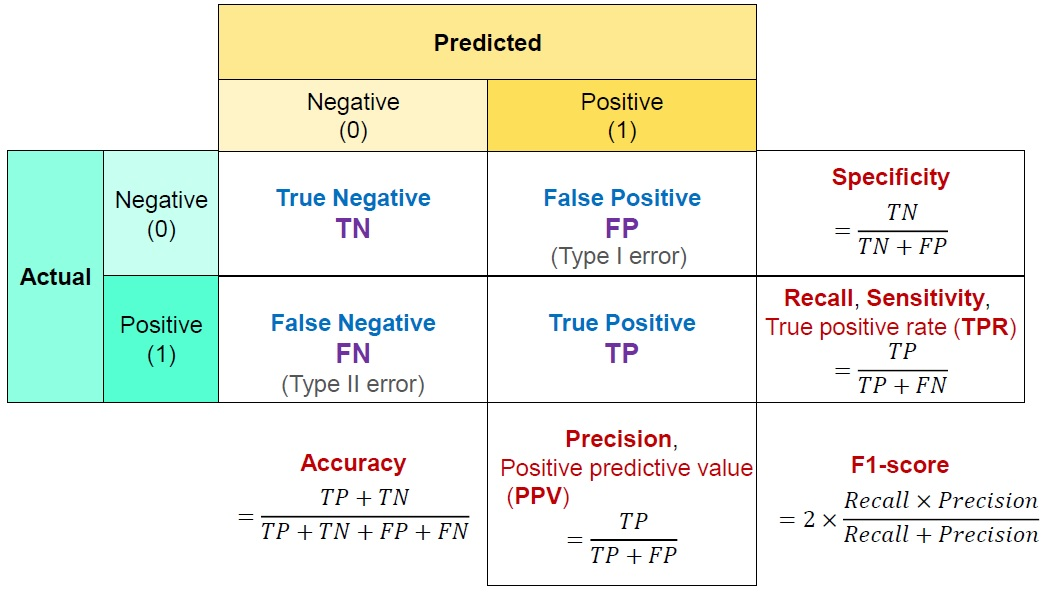

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      6796
           1       0.86      0.95      0.90      6797

    accuracy                           0.90     13593
   macro avg       0.90      0.90      0.90     13593
weighted avg       0.90      0.90      0.90     13593

              precision    recall  f1-score   support

           0       0.86      0.78      0.81      6796
           1       0.80      0.87      0.83      6797

    accuracy                           0.82     13593
   macro avg       0.83      0.82      0.82     13593
weighted avg       0.83      0.82      0.82     13593

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      6796
           1       0.81      0.89      0.84      6797

    accuracy                           0.84     13593
   macro avg       0.84      0.84      0.84     13593
weighted avg       0.84      0.84      0.84     13593



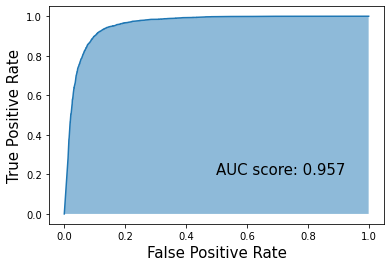

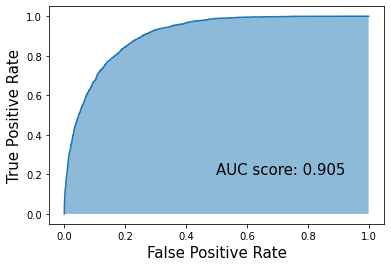

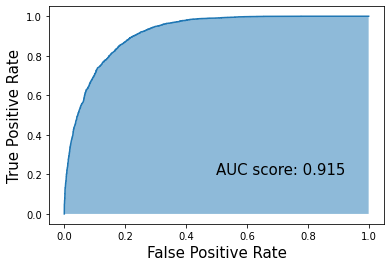

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
y_pred_rf = model_rf.predict_proba(X_val)
y_pred_xgb = model_xgb.predict_proba(X_val)
y_pred_lgbm = model_lgbm.predict_proba(X_val)

score_rf = roc_auc_score(y_val, y_pred_rf[:,1])
score_xgb = roc_auc_score(y_val, y_pred_xgb[:,1])
score_lgbm = roc_auc_score(y_val, y_pred_lgbm[:,1])

for pred in [y_pred_rf, y_pred_xgb, y_pred_lgbm]:
  fpr, tpr, _ = roc_curve(y_val, pred[:,1])
  plt.figure()
  plt.plot(fpr, tpr)
  plt.fill_between(fpr, tpr, alpha = 0.5)
  plt.xlabel('False Positive Rate', fontsize=15)
  plt.ylabel('True Positive Rate', fontsize=15)
  score = roc_auc_score(y_val, pred[:,1])
  plt.text(0.5,0.2,"AUC score: {:.3f}".format(score), fontsize=15)

print(classification_report(y_val, model_rf.predict(X_val)))
print(classification_report(y_val, model_xgb.predict(X_val)))
print(classification_report(y_val, model_lgbm.predict(X_val)))

In [ ]:
model_xgb2 = XGBClassifier(n_estimator=1000, learning_rate=0.1, max_depth=10, random_state=42)
model_xgb2.fit(
    X_tr, y_tr.values.ravel(),
    early_stopping_rounds=50,
    eval_metric='auc',
    eval_set=[(X_val, y_val)],
    verbose=10
    )

[0]	validation_0-auc:0.892071
Will train until validation_0-auc hasn't improved in 50 rounds.


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[10]	validation_0-auc:0.906922
[20]	validation_0-auc:0.913354
[30]	validation_0-auc:0.917052
[40]	validation_0-auc:0.919451
[50]	validation_0-auc:0.921198
[60]	validation_0-auc:0.922309
[70]	validation_0-auc:0.922933
[80]	validation_0-auc:0.924786
[90]	validation_0-auc:0.926384
[99]	validation_0-auc:0.927401


XGBClassifier(max_depth=10, n_estimator=1000, random_state=42)